#OpenVINO Pretrained Model 影像分割範例

歐尼克斯實境互動工作室 OmniXRI Jack, 2021.6.18

# 1. 安裝Intel OpenVINO工具包
以apt方式安裝OpenVINO，安裝版本為 2021.3.394  
預設安裝路徑為/opt/intel/OpenVINO_2021.3.394，系統會自建出/opt/intel/OpenVINO_2021捷徑名稱，後續可使用這個較短捷徑名稱。

In [1]:
# 顯示目前工作目錄
!pwd
# 取得OpenVINO 2021公開金錀
!wget https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 加入OpenVINO公開金錀到系統金錀群中
!apt-key add GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 建立更新安裝清單檔案
!touch /etc/apt/sources.list.d/intel-openvino-2021.list
# 將下載指令加入安裝清單中
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" >> /etc/apt/sources.list.d/intel-openvino-2021.list
# 更新系統
!apt update
# 安裝OpenVINO到虛擬機系統中
!apt install intel-openvino-dev-ubuntu18-2021.3.394
# 列出安裝路徑下內容進行確認
!ls /opt/intel

/content
--2021-06-17 15:46:56--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021
Resolving apt.repos.intel.com (apt.repos.intel.com)... 23.7.125.34, 2600:1407:3c00:3a0::4b23, 2600:1407:3c00:380::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|23.7.125.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘GPG-PUB-KEY-INTEL-OPENVINO-2021.2’

GPG-PUB-KEY-INTEL-O 100%[===================>]     939  --.-KB/s    in 0s      

2021-06-17 15:46:56 (198 MB/s) - ‘GPG-PUB-KEY-INTEL-OPENVINO-2021.2’ saved [939/939]

OK
Hit:1 https://apt.repos.intel.com/openvino/2021 all InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_6

# 2.下載模型

可選用影像分割模型為

*    deeplabv3
*    fastseg-large
*    fastseg-small
*    hrnet-v2-c1-segmentation
*    icnet-camvid-ava-????
*    icnet-camvid-ava-sparse-??-????
*    road-segmentation-adas-????
*    semantic-segmentation-adas-????
*    unet-camvid-onnx-????

這裡選用 **--name deeplabv3** （可自行變更所需模型名稱）

In [2]:
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py --name deeplabv3

[setupvars.sh] OpenVINO environment initialized
################|| Downloading deeplabv3 ||################

========== Downloading /content/public/deeplabv3/deeplabv3.tar.gz
... 100%, 23323 KB, 17318 KB/s, 1 seconds passed

========== Unpacking /content/public/deeplabv3/deeplabv3.tar.gz



# 3.模型轉換

如果下載的是Intel Pretrained Model則不需轉換就自帶IR檔(xml,bin)  
若是Public Pretrained Model則須進行轉換成IR檔，系統會自動判別。  
--name 參數為待轉換模型名稱

In [3]:
# 下載及安裝test-generator 方便檢查程式運行錯誤
!pip3 install test-generator==0.1.1

# 執行環境設定批次檔並將下載到的模型檔進行轉換產生IR(xml & bin)檔
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/converter.py \
--name deeplabv3

# 檢查模型轉檔後會產生/FP16, FP32不同精度的IR檔(xml, bin)
!ls public/deeplabv3
!ls public/deeplabv3/FP32

[setupvars.sh] OpenVINO environment initialized
========== Converting deeplabv3 to IR (FP16)
Conversion command: /usr/bin/python3 -- /opt/intel/openvino_2021/deployment_tools/model_optimizer/mo.py --framework=tf --data_type=FP16 --output_dir=/content/public/deeplabv3/FP16 --model_name=deeplabv3 --reverse_input_channels '--input_shape=[1,513,513,3]' --input=1:mul_1 --output=ArgMax --input_model=/content/public/deeplabv3/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/content/public/deeplabv3/deeplabv3_mnv2_pascal_train_aug/frozen_inference_graph.pb
	- Path for generated IR: 	/content/public/deeplabv3/FP16
	- IR output name: 	deeplabv3
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	1:mul_1
	- Output layers: 	ArgMax
	- Input shapes: 	[1,513,513,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 

# 4.準備測試影像

從網路獲取任意一張測試影像並顯示

In [4]:
# 導入必要函式庫
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

# 建立顯示BGR格式影像函式
def show_bgr(bgr_image):
    rgb = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB) # 將影像從BGR格式轉到RGB格式，才能讓plt.imshow()正確顯示
    plt.figure() # 準備一顯示影像空間
    plt.axis("off") # 設定關閉XY軸刻尺
    plt.imshow(rgb) # 顯示影像

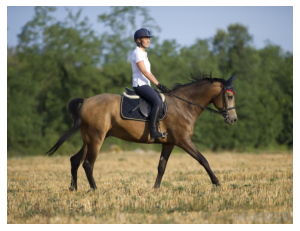

In [5]:
# 從網路獲取一張影像
file = requests.get("https://images.wisegeek.com/woman-riding-horse.jpg")
# 將影像轉成OpenCV格式存入img中
img = cv2.imdecode(np.frombuffer(file.content, np.uint8), 1)
# 將img寫入磁碟命名為input.jpg
cv2.imwrite('input.jpg',img)

# 亦可直接讀取本地端影像
# img = cv2.imread('input.jpg')

# 顯示BGR格式影像
show_bgr(img)

為更清楚了解物件偵測範例程式可支援的模型，可將models.lst及使用方式列出來確認。（此步驟可忽略）

In [6]:
!cat /opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/models.lst

# This file can be used with the --list option of the model downloader.
deeplabv3
fastseg-large
fastseg-small
hrnet-v2-c1-segmentation
icnet-camvid-ava-????
icnet-camvid-ava-sparse-??-????
road-segmentation-adas-????
semantic-segmentation-adas-????
unet-camvid-onnx-????


# 5.進行推論

物件偵測範例程式 segmentation_demo.py

輸入參數：  
-i 輸入檔案名稱 (可支援單張影像或影片檔)  
-m 模型名稱 (.xml)  
-o 輸出結果名稱 (.png, *.jpg ...)  

最後顯示推論結果，會以顏色區分不同物件，可被分割出來的內容會依不同模型所預訓練的資料集而有所不同，請自行參考  
https://docs.openvinotoolkit.org/latest/omz_models_group_public.html  

[setupvars.sh] OpenVINO environment initialized
[ INFO ] Initializing Inference Engine...
[ INFO ] Loading network...
[ INFO ] Reading network from IR...
[ INFO ] Loading network to CPU plugin...
[ INFO ] Starting inference...
To close the application, press 'CTRL+C' here or switch to the output window and press ESC key
OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 8 and format 'image2 / image2 sequence'
Unable to init server: Could not connect: Connection refused
Traceback (most recent call last):
  File "/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/segmentation_demo.py", line 267, in <module>
    sys.exit(main() or 0)
  File "/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/segmentation_demo.py", line 232, in main
    cv2.imshow('Segmentation Results', frame)
cv2.error: OpenCV(4.5.2-openvino) ../opencv/modules/highgui/src/window_gtk.cpp:624: error: (-2:Unspecified error) Can't

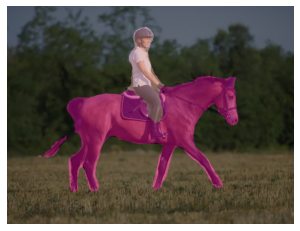

In [7]:
# 設定環境變數及進行影像分割推論
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 \
/opt/intel/openvino_2021/deployment_tools/inference_engine/demos/segmentation_demo/python/segmentation_demo.py \
-i 'input.jpg' \
-m public/deeplabv3/FP32/deeplabv3.xml \
-o 'output.jpg'

# 讀取輸出結果影像
img = cv2.imread('output.jpg')
# 顯示BGR格式影像
show_bgr(img)